# 04 - Applied ML

## Deadline
Tuesday November 22, 2016 at 11:59PM

## Background
In this homework we will gain experience on Applied Machine Learning, exploring an interesting dataset about soccer players and referees.
You can find all the data in the `CrowdstormingDataJuly1st.csv` file, while you can read a thorough [dataset description here](DATA.md).
Given that the focus of this homework is Machine Learning, I recommend you to first take a look at [this notebook](http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb)
containing a solid work in pre-processing + visualization of the given dataset. You are *not* allowed to just copy/paste the pre-processing steps
performed by the notebook authors -- you are still supposed to perform your own data analysis for the homework. Still, I'm confident that consulting first
the work done by expert data analysts will speed up tangibly your effort (i.e., they have already found for you many glitches in the data :)


## Assignment
1. Train a `sklearn.ensemble.RandomForestClassifier` that given a soccer player description outputs his skin color. Show how different parameters 
passed to the Classifier affect the overfitting issue. Perform cross-validation to mitigate the overfitting of your model. Once you assessed your model,
inspect the `feature_importances_` attribute and discuss the obtained results. With different assumptions on the data (e.g., dropping certain features even
before feeding them to the classifier), can you obtain a substantially different `feature_importances_` attribute?

  *BONUS*: plot the learning curves against at least 2 different sets of parameters passed to your Random Forest. To obtain smooth curves, partition
your data in at least 20 folds. Can you find a set of parameters that leads to high bias, and one which does not?

2. Aggregate the referee information grouping by soccer player, and use an unsupervised learning technique to cluster the soccer players in 2 disjoint
clusters. Remove features iteratively, and at each step perform again the clustering and compute the silhouette score -- can you find a configuration of features with high silhouette
score where players with dark and light skin colors belong to different clusters? Discuss the obtained results.


----

# Data Description

From a company for sports statistics, we obtained data and profile photos from all soccer players (N = 2053) playing in the first male divisions of England, Germany, France and Spain in the 2012-2013 season and all referees (N = 3147) that these players played under in their professional career. We created a dataset of player–referee dyads including the number of matches players and referees encountered each other and our dependent variable, the number of red cards given to a player by a particular referee throughout all matches the two encountered each other.
 
Player photos were available from the source for 1586 out of 2053 players. Players’ skin tone was coded by two independent raters blind to the research question who, based on their profile photo, categorized players on a 5-point scale ranging from “very light skin” to “very dark skin” with “neither dark nor light skin” as the center value. 

Additionally, implicit bias scores for each referee country were calculated using a race implicit association test (IAT), with higher values corresponding to faster white | good, black | bad associations. Explicit bias scores for each referee country were calculated using a racial thermometer task, with higher values corresponding to greater feelings of warmth toward whites versus blacks. Both these measures were created by aggregating data from many online users in referee countries taking these tests on [Project Implicit](http://projectimplicit.net).

In all, the dataset has a total of 146028 dyads of players and referees. A detailed description of all variables in the dataset can be seen in the list below.

## Variables:

*playerShort* - short player ID

*player* - player name

*club* - player club

*leagueCountry* - country of player club (England, Germany, France, and Spain)

*birthday* - player birthday

*height* - player height (in cm)

*weight* - player weight (in kg)

*position* - detailed player position

*games* - number of games in the player-referee dyad

*victories* - victories in the player-referee dyad

*ties* - ties in the player-referee dyad

*defeats* - losses in the player-referee dyad

*goals* - goals scored by a player in the player-referee dyad

*yellowCards* - number of yellow cards player received from referee

*yellowReds* - number of yellow-red cards player received from referee

*redCards* - number of red cards player received from referee

*photoID* - ID of player photo (if available)

*rater1* - skin rating of photo by rater 1 (5-point scale ranging from “very light skin” to “very dark skin”)

*rater2* - skin rating of photo by rater 2 (5-point scale ranging from “very light skin” to “very dark skin”)

*refNum* - unique referee ID number (referee name removed for anonymizing purposes)

*refCountry* - unique referee country ID number (country name removed for anonymizing purposes)

*meanIAT* - mean implicit bias score (using the race IAT) for referee country, higher values correspond to faster white | good, black | bad associations

*nIAT* - sample size for race IAT in that particular country

*seIAT* - standard error for mean estimate of race IAT

*meanExp* - mean explicit bias score (using a racial thermometer task) for referee country, higher values correspond to greater feelings of warmth toward whites versus blacks

*nExp* - sample size for explicit bias in that particular country

*seExp* - standard error for mean estimate of explicit bias measure


---
# Links & Resources

sklearn : 
* [Feature importances with forests of trees](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
* [Label encoder](http://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.LabelEncoder.html)
* [Random Forest Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

---
# Experiments

In [91]:
# Import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline


In [92]:
filename='CrowdstormingDataJuly1st.csv'
df = pd.read_csv(filename)

In [93]:
df.sample(10)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
101372,ibai,Ibai,Athletic Bilbao,Spain,11.11.1989,177.0,72.0,Left Winger,1,0,...,0.00,2176,48,ITA,0.386174,1761.0,0.000232,0.529815,1895.0,0.001091
81628,maxwell,Maxwell,Paris Saint-Germain,France,27.08.1981,175.0,73.0,Left Fullback,2,0,...,0.25,1766,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
127335,jason-roberts,Jason Roberts,Reading FC,England,25.01.1978,186.0,89.0,Center Forward,1,0,...,0.75,2721,44,ENGL,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037
111003,bueno,Bueno,Real Valladolid,Spain,20.03.1988,178.0,64.0,Center Forward,3,2,...,0.25,2359,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
145983,jussie,Jussiê,Girondins Bordeaux,France,19.09.1983,180.0,76.0,Left Winger,1,1,...,0.50,3147,21,HUN,0.376127,574.0,0.000714,0.498350,606.0,0.002968
104132,corby-moore,Corby Moore,Southampton FC,England,21.11.1993,NaN,NaN,NaN,1,1,...,NaN,2239,44,ENGL,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037
49364,jeff-louis,Jeff Louis,AS Nancy,France,08.08.1992,178.0,70.0,Center Midfielder,1,0,...,NaN,941,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
142863,stefan-aigner,Stefan Aigner,Eintracht Frankfurt,Germany,20.08.1987,185.0,72.0,Right Midfielder,2,1,...,0.00,3065,8,DEU,0.336628,7749.0,0.000055,0.335967,7974.0,0.000225
40015,arthur-boka,Arthur Boka,VfB Stuttgart,Germany,02.04.1983,166.0,67.0,Left Fullback,3,2,...,1.00,749,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
70449,giovani-dos-santos,Giovani Dos Santos,RCD Mallorca,Spain,11.05.1989,175.0,74.0,Right Winger,1,1,...,0.75,1522,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [94]:
df['skintone']=(df['rater1']+df['rater2'])/2
df['allreds']=df['yellowReds']+df['redCards']

In [95]:
df.sample(10)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skintone,allreds
60233,matthieu-valbuena,Matthieu Valbuena,Olympique Marseille,France,28.09.1984,167.0,58.0,Right Midfielder,1,1,...,15,TUR,0.354707,656.0,0.000606,0.182081,692.0,0.002717,0.000,0
43784,luna,Luna,Sevilla FC,Spain,17.03.1991,177.0,68.0,Left Fullback,1,1,...,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,0.375,0
121575,brahim-ferradj,Brahim Ferradj,Stade Brest,France,04.09.1987,172.0,74.0,NaN,1,0,...,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586,NaN,0
81766,bruno-gama,Bruno Gama,Deportivo La Coruña,Spain,15.11.1987,175.0,68.0,Right Winger,1,0,...,72,PRT,0.396803,1079.0,0.000392,0.790366,1121.0,0.001798,0.250,0
19501,raphael-holzhauser,Raphael Holzhauser,VfB Stuttgart,Germany,16.02.1993,193.0,85.0,Center Midfielder,1,0,...,8,DEU,0.336628,7749.0,0.000055,0.335967,7974.0,0.000225,0.125,0
77829,sami-khedira,Sami Khedira,Real Madrid,Spain,04.04.1987,189.0,85.0,Center Midfielder,1,0,...,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586,0.250,0
19006,diego-godin,Diego Godín,Atlético Madrid,Spain,16.02.1986,185.0,75.0,Center Back,1,0,...,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586,0.250,0
102386,marcel-schmelzer,Marcel Schmelzer,Borussia Dortmund,Germany,22.01.1988,181.0,74.0,Left Fullback,2,1,...,8,DEU,0.336628,7749.0,0.000055,0.335967,7974.0,0.000225,0.000,0
136511,thomas-pledl,Thomas Pledl,SpVgg Greuther Fürth,Germany,23.05.1994,174.0,65.0,NaN,2,0,...,8,DEU,0.336628,7749.0,0.000055,0.335967,7974.0,0.000225,0.000,0
34558,milorad-pekovic,Milorad Peković,SpVgg Greuther Fürth,Germany,05.08.1977,189.0,88.0,Defensive Midfielder,1,1,...,48,ITA,0.386174,1761.0,0.000232,0.529815,1895.0,0.001091,0.125,1


Explained in [here](https://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb). The idea is basically to "disaggregate" the data : the current df holds dyads of interactions between a player and a ref. This means they can have several games in common and several interactions. So we'll split everything so each row is an interaction between a player and a ref, not the sum of interactions between the two.

In [96]:
#disag = [0 for _ in range(sum(df['games']))]
#j=0

#for _, row in df.iterrows():
#    reds_row = row['allreds']
#    for game in range(row['games']):
#        row['allreds'] = 1 if (reds_row - game > 0) else 0
#        disag[j] = list(row)
#        j+=1
        
#pd.DataFrame(disag, columns=list(df.columns)).to_csv('crowdstorm_disaggregated.csv', index=False) 

They noticed that there are lots of referees with less than 22 dyads (the median was even 11 dyads), which should not be possible as there are 22 players on the pitch during a game : this means if a ref is at a game he will have a dyad with every one of the 22 players. In other words, referees with more than one game have more than 22 references. 

Apparently the issue is that the numbers for the referees include the interactions for the entire career : i.e. if in 2002 this ref gave a red card to a player it'll appear in the dyad between him and the player. BUT the player data is only for 2012-2013. So we'll filter the data so that every ref has at least 22 dyads (if there are less it corresponds to an old interaction)

In [97]:
dfd = pd.read_csv('crowdstorm_disaggregated.csv')

allRefs = dfd.refNum.value_counts()
goodRefs = allRefs[allRefs > 21]
#Copying from 
#http://stackoverflow.com/questions/12065885/how-to-filter-the-dataframe-rows-of-pandas-by-within-in
#
#This line defines a new dataframe based on our >21 games filter
disag_good = dfd[dfd['refNum'].isin(goodRefs.index.values)]
disag_good.sample(10)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skintone,allreds
54860,gael-danic,Gaël Danic,Valenciennes FC,France,19.11.1981,176.0,65.0,Left Midfielder,4,2,...,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586,0.000,0
115258,iker-casillas,Iker Casillas,Real Madrid,Spain,20.05.1981,185.0,84.0,Goalkeeper,6,3,...,8,DEU,0.336628,7749.0,0.000055,0.335967,7974.0,0.000225,0.000,0
157905,david-jones,David Jones,Wigan Athletic,England,04.11.1984,180.0,66.0,Defensive Midfielder,2,1,...,44,ENGL,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037,0.125,0
153306,samir-nasri,Samir Nasri,Manchester City,England,26.06.1987,177.0,75.0,Attacking Midfielder,1,0,...,48,ITA,0.386174,1761.0,0.000232,0.529815,1895.0,0.001091,0.000,0
200700,duda_2,Duda,Málaga CF,Spain,27.06.1980,175.0,71.0,Left Midfielder,5,2,...,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002,0.250,0
339806,jean-beausejour,Jean Beausejour,Wigan Athletic,England,01.06.1984,178.0,81.0,Left Midfielder,6,2,...,44,ENGL,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037,0.500,0
273930,jonathan-zebina,Jonathan Zebina,Toulouse FC,France,19.07.1978,190.0,84.0,Right Fullback,10,7,...,48,ITA,0.386174,1761.0,0.000232,0.529815,1895.0,0.001091,0.500,0
304596,mikel-arteta,Mikel Arteta,Arsenal FC,England,26.03.1982,176.0,69.0,Attacking Midfielder,4,3,...,44,ENGL,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037,0.000,0
234911,julien-palmieri,Julien Palmieri,SC Bastia,France,07.12.1986,170.0,64.0,Attacking Midfielder,4,1,...,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586,NaN,0
59254,nicolas-fauvergue,Nicolas Fauvergue,Stade Reims,France,13.10.1984,191.0,81.0,Center Forward,5,1,...,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586,0.250,0


---
# 1. Random Forest Classifier

We want to train a `RandomForestClassifier` to predict a player's skin color based on the player's description.

In [98]:
# Import stuff
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np


### 1.1 Loading the data

The first step is of course to load the data provided to us in `CrowdstormingDataJuly1st.csv`. Its fields are described above for reference.

In [99]:
filename='CrowdstormingDataJuly1st.csv'
df = pd.read_csv(filename)
df.sample(10)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
17709,ilan,Ilan,SC Bastia,France,18.09.1980,180.0,69.0,Right Winger,3,1,...,0.25,362,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
108349,moises_2,Moisés,Granada CF,Spain,20.02.1981,185.0,85.0,Defensive Midfielder,1,1,...,0.25,2316,58,BEL,0.362720,3219.0,0.000128,0.568785,3351.0,0.000575
5657,jose-enrique,José Enrique,Liverpool FC,England,23.01.1986,184.0,82.0,Left Fullback,1,0,...,0.00,137,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
21750,jamie-ness,Jamie Ness,Stoke City,England,02.03.1991,177.0,NaN,NaN,2,1,...,NaN,421,45,SCOT,0.326690,44791.0,0.000010,0.356446,46916.0,0.000037
20830,thomas-kahlenberg,Thomas Kahlenberg,VfL Wolfsburg,Germany,20.03.1983,183.0,72.0,Attacking Midfielder,5,2,...,0.00,402,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586
136732,shinji-okazaki,Shinji Okazaki,VfB Stuttgart,Germany,16.04.1986,173.0,70.0,Center Forward,1,1,...,0.25,2905,8,DEU,0.336628,7749.0,0.000055,0.335967,7974.0,0.000225
16749,jerome-boateng,Jérôme Boateng,Bayern München,Germany,03.09.1988,192.0,90.0,Center Back,1,1,...,0.75,347,8,DEU,0.336628,7749.0,0.000055,0.335967,7974.0,0.000225
105709,wilson-palacios,Wilson Palacios,Stoke City,England,29.07.1984,178.0,71.0,Defensive Midfielder,1,0,...,0.75,2273,27,ROU,0.385082,537.0,0.000756,0.859431,562.0,0.003620
23493,maxwell,Maxwell,Paris Saint-Germain,France,27.08.1981,175.0,73.0,Left Fullback,7,6,...,0.25,434,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
104819,frederic-sammaritano,Frédéric Sammaritano,AC Ajaccio,France,23.03.1986,162.0,61.0,NaN,3,1,...,0.25,2246,7,FRA,0.334684,2882.0,0.000151,0.336101,3011.0,0.000586


### 1.2 Cleaning the data

A few things have to be done to clean the data before we feed it to the classifier.

Firstly, let's merge the two skin color ratings into a mean one, since this score will act as our label for the classifier, and remove the two rating columns.

In [100]:
df['skintone']=(df['rater1']+df['rater2'])/2
df = df.drop('rater1', 1)
df = df.drop('rater2', 1)

Secondly, let's remove players who don't have this rating since we won't be able to train the classifier with these examples. They are currently store as `NaN` scpre in the `skintone` column.

In [101]:
clean_df = df.copy()
len(clean_df)

146028

In [102]:
clean_df = clean_df.dropna(axis=0, subset = ['skintone'])
len(clean_df) - len(clean_df.dropna(axis=0))

9164

Let's now check for other missing values :

In [103]:
for column in clean_df:
    print(column + ':', len(clean_df[column].iloc[clean_df[column].isnull().nonzero()]))

playerShort: 0
player: 0
club: 0
leagueCountry: 0
birthday: 0
height: 46
weight: 753
position: 8461
games: 0
victories: 0
ties: 0
defeats: 0
goals: 0
yellowCards: 0
yellowReds: 0
redCards: 0
photoID: 0
refNum: 0
refCountry: 0
Alpha_3: 1
meanIAT: 153
nIAT: 153
seIAT: 153
meanExp: 153
nExp: 153
seExp: 153
skintone: 0


We can see that the features `meanIAT`, `nIAT`, `seIAT`, `meanExp`, `nExp` and `seExp` correspond to the same entries of the dataset. Let's look their distribution by country because thats how they have been collected.

In [104]:
for country in clean_df['leagueCountry'].unique():
    print(country + '\n', clean_df['meanIAT'][clean_df['leagueCountry'] == country].describe())
for country in clean_df['leagueCountry'].unique():
    print(country + '\n', clean_df['nIAT'][clean_df['leagueCountry'] == country].describe())

Spain
 count    30968.000000
mean         0.360991
std          0.029947
min         -0.047254
25%          0.345305
50%          0.369894
75%          0.369894
max          0.573793
Name: meanIAT, dtype: float64
France
 count    18916.000000
mean         0.343024
std          0.037566
min         -0.047254
25%          0.334684
50%          0.334684
75%          0.355498
max          0.573793
Name: meanIAT, dtype: float64
England
 count    35145.000000
mean         0.343323
std          0.032956
min         -0.047254
25%          0.326690
50%          0.334684
75%          0.362015
max          0.573793
Name: meanIAT, dtype: float64
Germany
 count    39439.000000
mean         0.344741
std          0.026943
min         -0.047254
25%          0.336628
50%          0.336628
75%          0.346294
max          0.573793
Name: meanIAT, dtype: float64
Spain
 count    3.096800e+04
mean     1.452977e+04
std      1.394920e+05
min      2.000000e+00
25%      1.761000e+03
50%      1.785000e+03
75% 

We conclude that only `meanIAT` has a mean that make sense with its standard deviation. In any case, with respect to the size of our dataset, set we can drop these entries from our dataframe.

In [105]:
# clean_df = clean_df.dropna(axis=0,subset=['meanIAT','nIAT','seIAT','meanExp','nExp','seExp']).reset_index()

For the 'position' feauture we conclude that it was not a important feature for our model. Finally, for the height and weigth missing values we made the assumption that soccer player have almost all a 'athletic' condition that depend on their weight, height and skintone.

In [106]:
idx_weight = clean_df.iloc[clean_df['weight'].isnull().nonzero()].index
idx_height = clean_df.iloc[clean_df['height'].isnull().nonzero()].index

for idx in idx_weight:
    mean_weight = clean_df['weight'][(clean_df['height'] == clean_df.iloc[idx].height) & 
                                     (clean_df['skintone'] == clean_df.iloc[idx].skintone)].mean() 
                       
    clean_df.set_value(idx, 'weight', mean_weight)

IndexError: single positional indexer is out-of-bounds

In [107]:
clean_df.iloc[idx_weight]

IndexError: positional indexers are out-of-bounds

We can now extract the labels that will be used to train the classifier.

We'll start by using all the features provided by the dataset to train the classifier, later figuring out which ones are actually interesting.

In [108]:
clean_df.columns

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'refNum',
       'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp',
       'seExp', 'skintone'],
      dtype='object')

In [128]:
to_drop = [
    'player', 'photoID', 'birthday',
    'refNum', 'meanIAT', 'nIAT', 'seIAT',
    'nExp', 'seExp', 'refCountry', 'meanExp',
]

final_df = clean_df.drop(to_drop, axis=1).dropna().groupby('playerShort').agg('first')
features = final_df.drop('skintone', axis=1)

for col in features.columns.values:
    le = LabelEncoder()
    labels = le.fit_transform(features[col])
    features[col] = labels
    
le = LabelEncoder()
labels = le.fit_transform(np.array(final_df['skintone']))

### 1.3 Training the classifier

We've now got our training data so let's try to train the `RandomForestClassifier`.

In [129]:
from sklearn.model_selection import train_test_split

# Split into a test and a train set
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.4)

# Create the RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100, random_state=12432)

# Train the model
clf = forest.fit(X_train, Y_train)

Let's now see how accurate our model is :

In [130]:
clf.score(X_test, Y_test)

0.31762652705061084

This is a simple scoring method, so let's perform cross-validation on it to make sure we actually get the desired score.

In [131]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_test, Y_test, cv=5)

print("Accuracy: %0.6f (+/- %0.6f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.288036 (+/- 0.073222)


### 1.5 Feature importances

We would like to figure out which of the features are the most relevant to our model (i.e. the features that represent the most variance / information). These are the features that help the classifier make its decision.

We have access to this information in `RandomForestClassifier.feature_importances_`, so we can plot their importance.

Feature ranking:
1. feature #0 club (0.154419)
2. feature #3 weight (0.148311)
3. feature #2 height (0.146745)
4. feature #4 position (0.113438)
5. feature #13 Alpha_3 (0.108068)
6. feature #5 games (0.057483)
7. feature #6 victories (0.054073)
8. feature #1 leagueCountry (0.052650)
9. feature #8 defeats (0.051735)
10. feature #7 ties (0.043508)
11. feature #10 yellowCards (0.033929)
12. feature #9 goals (0.029829)
13. feature #11 yellowReds (0.003524)
14. feature #12 redCards (0.002288)


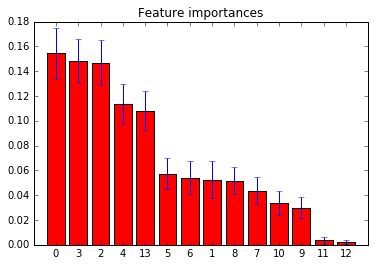

In [90]:
# Plot code adapted from :
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

indices = np.argsort(importances)[::-1]

feature_names = features.columns.values.tolist()

# Print the feature ranking
print("Feature ranking:")

for j in range(X_test.shape[1]):
    print("%d. feature #%d %s (%f)" % (j + 1, indices[j], feature_names[indices[j]], importances[indices[j]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_test.shape[1]), indices)
plt.xlim([-1, X_test.shape[1]])
plt.show()

### 1.4 Learning Curves

We want to see how our model's accuracy evolves with the number of samples. For this we can plot a learning curve, which will randomly split the data into test and training sets using a `ShuffleSplit`. It will then train the model and compute its score over the test set. We can then plot the accuracy over the number of training examples.

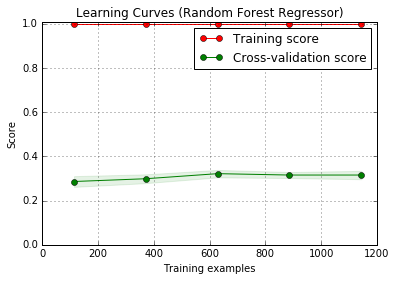

In [132]:
# Plot code adapted from :
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
#
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def run_learning_curve():

    # Legends
    title  = "Learning Curves (Random Forest Regressor)"
    xlabel = "Training examples"
    ylabel = "Score"

    # Plots params
    y_lim = (0.0, 1.01)

    # CV params
    train_sizes = np.linspace(.1, 1.0, 5)
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

    plt.figure()
    plt.title(title)
    plt.ylim(*y_lim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    train_sizes, train_scores, test_scores = learning_curve(forest, features, labels, cv=cv, n_jobs=4, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores , axis=1)

    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_std   = np.std(test_scores , axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")


    plt.show()
    
run_learning_curve()

## 2. Clustering

In [135]:
from sklearn.cluster import KMeans

In [137]:
clean_df.columns.values

array(['playerShort', 'player', 'club', 'leagueCountry', 'birthday',
       'height', 'weight', 'position', 'games', 'victories', 'ties',
       'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards',
       'photoID', 'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT',
       'seIAT', 'meanExp', 'nExp', 'seExp', 'skintone'], dtype=object)

In [293]:
to_drop = [
    'player', 'photoID', 'birthday', 'games',
    'refNum', 'refCountry', 'victories', 'ties', 'defeats',
    'meanExp', 'nExp', 'seExp',
    
    'leagueCountry', 'weight', 'position', 'meanExp', 'nExp', 'seExp',
    
    # 'yellowCards', 'yellowReds', 'redCards',
    #'meanIAT', 'nIAT', 'seIAT'
    
    'club', 'height', 'Alpha_3'
]

agg = {
    # 'player'        : 'first',
    # 'club'          : 'first',
    #'leagueCountry' : 'first',
    # 'birthday'      : 'first',
    #'height'        : 'first',
    #'weight'        : 'first',
    #'position'      : 'first',
    # 'games'         : 'sum',
    # 'victories'     : 'sum',
    # 'ties'          : 'sum',
    # 'defeats'       : 'sum',
    # 'goals'         : 'sum',
    'yellowCards'   : 'sum',
    'yellowReds'    : 'sum',
    'redCards'      : 'sum',
    # 'photoID'       : 'first',
    # 'refNum'        : 'first',
    # 'refCountry'    : 'first',
    #'Alpha_3'       : 'first',
    'meanIAT'       : 'mean',
    'nIAT'          : 'mean',
    'seIAT'         : 'mean',
    # 'meanExp'       : 'mean',
    # 'nExp'          : 'mean',
    # 'seExp'         : 'mean',
    'skintone'      : 'mean'
}

cluster_df = clean_df.drop(to_drop, axis=1).dropna().groupby('playerShort').agg(agg)

cluster_df

,nIAT,meanIAT,yellowCards,redCards,yellowReds,skintone,seIAT
playerShort,,,,,,,
aaron-hughes,19710.156627,0.346459,19,0,0,0.125,0.000652
aaron-hunt,26104.292929,0.348818,42,1,0,0.125,0.000219
aaron-lennon,21234.861386,0.345893,11,0,0,0.250,0.000367
aaron-ramsey,38285.826923,0.346821,31,1,0,0.000,0.003334
abdelhamid-el-kaoutari,2832.351351,0.331600,8,2,4,0.250,0.001488
abdou-traore_2,4523.666667,0.320079,11,0,1,0.750,0.002797
abdoulaye-diallo_2,2646.700000,0.341625,0,0,0,0.875,0.000237
abdoulaye-keita_2,1728.000000,0.355406,0,0,0,0.875,0.000433
abdoulwhaid-sissoko,2470.196429,0.348178,21,2,0,1.000,0.000180


In [294]:
encoders = {}

for col in cluster_df.columns.values:
    if agg[col] != 'first':
        continue
    le = LabelEncoder()
    labels = le.fit_transform(cluster_df[col])
    cluster_df[col] = labels
    encoders[col] = le

In [295]:
kmeans = KMeans(n_clusters=2, max_iter=100, n_init=5, n_jobs=4, random_state=42)

dataset = cluster_df.reset_index().drop(['playerShort', 'skintone'], axis=1)

dist = kmeans.fit_transform(dataset)

In [296]:
def cluster_num(x, axis=None):
    if x['cluster1'] < x['cluster2']:
        return 1
    else:
        return 2
        
dist_df = pd.DataFrame(dist, columns=['cluster1', 'cluster2'])

with_dist = cluster_df.reset_index().join(dist_df)
with_dist['cluster_num'] = with_dist.apply(cluster_num,  axis=1)

only_skin = with_dist[['playerShort', 'skintone', 'cluster_num']]
only_skin

,playerShort,skintone,cluster_num
0,aaron-hughes,0.125,1
1,aaron-hunt,0.125,1
2,aaron-lennon,0.250,1
3,aaron-ramsey,0.000,1
4,abdelhamid-el-kaoutari,0.250,1
5,abdou-traore_2,0.750,1
6,abdoulaye-diallo_2,0.875,1
7,abdoulaye-keita_2,0.875,1
8,abdoulwhaid-sissoko,1.000,1
9,abdul-rahman-baba,0.875,1


In [297]:
only_skin[only_skin['cluster_num'] == 1].describe()

,skintone,cluster_num
count,1564.000000,1564.0
mean,0.287404,1.0
std,0.289332,0.0
min,0.000000,1.0
25%,0.000000,1.0
50%,0.250000,1.0
75%,0.375000,1.0
max,1.000000,1.0


In [298]:
only_skin[only_skin['cluster_num'] == 2].describe()

,skintone,cluster_num
count,21.000000,21.0
mean,0.446429,2.0
std,0.365657,0.0
min,0.000000,2.0
25%,0.125000,2.0
50%,0.375000,2.0
75%,0.750000,2.0
max,1.000000,2.0
